In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Suicide analyse in the world and Germany. Model ot predict potential suicides based on text messages.

## Table of content:

1. Introduction

2. Suicide data - world overview<br>
2.1 Data acquisition and Data familiarisation<br>
2.2 Data tidying and cleaning<br>
3.3 Data visualization<br>
&emsp;3.3.1 Male vs Female<br>
&emsp;3.3.2 Suicides per country<br>
&emsp;3.3.3 Year distribution<br>

3. Suicide data - focus on Germany<br>
3.1 Data acquisition and Data familiarisation<br>
3.2 Data tidying and cleaning<br>
3.3 Data visualization<br>
&emsp;3.3.1 Male vs Female<br>
&emsp;3.3.2 Age group distribution<br>
&emsp;3.3.3 Generation<br>
&emsp;3.3.3 Year distribution<br>

4. West Germany Suicide<br>
4.1 Data acquisition and Data familiarisation<br>
4.2 Data tidying and cleaning<br>
4.3 Data visualization<br>
&emsp;4.3.1 Suicide method distribution<br>
&emsp;4.3.2 Age group distribution<br>

5. Suicide detection per text message<br>
5.1 Data acquisition and Data familiarisation<br>
5.2 Data tidying and cleaning<br>

6. Modeling<br>
6.1 Model training<br>
6.2 Model results<br>

7. Limitations and further improvements<br>


### 1. Introduction

According to the World Health Organization (WHO) every 40 seconds a person dies from a suicide where the most affected age group are young people, especially young men. 
In this work I want to analyse what the causes for committing a suicide might be and what methods are mostly used. Furthermore I will try creating a model which can predict the vulnerability of a person for committing a suicide.<br>
In this project I will first analyse data about people who are prone to commit a suicide. More specifically, I will first take a dataset which contains data from many countries across the world. After that I will analyse another dataset which refers to the suicides in Germany and to be more precise I will focus on the methods that people chose to commit a suicide. Last but not least, I will use a third dataset to create a model which tries to predict whether a person will suicide or not based on a text message.

**sources:**<br>
https://www.who.int/news/item/09-09-2019-suicide-one-person-dies-every-40-seconds<br>
https://save.org/about-suicide/suicide-statistics/

### 2. Suicide data - world overview

#### 2.1 Data acquisition and Data familiarisation

I will start with a dataset that contains data about committed suicides for each country for the time span of 32 years (from 1985 till 2016). Lets first read the dataset and check some basic informations about it (like shape, columns and what they show, type of the data in the columns etc.)

In [3]:
suicide_data_world = pd.read_csv("data/Suicide World.csv")

Ok, lets first visualize the first 10 rows of the dataset to get some overview:

In [4]:
suicide_data_world.head(10)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


It looks god, now I want to check the shape, the names of the columns and the types of the data in them:

In [5]:
suicide_data_world.shape

(27820, 12)

In [6]:
suicide_data_world.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [7]:
suicide_data_world.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object

Hm, ok, first of all the column names are pretty ok with some exceptions, but I will convert them in an appropriate format in a while. The types of the data in the columns look pretty fine and for now I will leave it as it is, but when I prepare the data for modelling, I will need to make some adjustments.<br>
For example, I can see that the year column is of type integer, but thats fine, because I do not have exact datetime for every row and I would not focus on that.<br>
Ok, now I will rename some columns which do not meet my criteria (column_name) so that all of them have the same format:

In [8]:
suicide_data_world.rename(columns = {
    "suicides/100k pop":"suicides_per_100k", "country-year":"country_year", 
    "HDI for year":"hdi_for_year", " gdp_for_year ($) ":"gdp_for_year_usd", 
    "gdp_per_capita ($)":"gdp_per_capita_usd"}, inplace = True)

In [9]:
suicide_data_world.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_per_100k', 'country_year', 'hdi_for_year', 'gdp_for_year_usd',
       'gdp_per_capita_usd', 'generation'],
      dtype='object')

Now it looks much better. Another think to check would be whether all the countries are in the dataset or we do have some missing countries.

In [10]:
suicide_data_world.country.unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

Well, I can clearly seen, that a lot of countries are still in the dataset, but there are also a lot of countries that are missing like for example China, Bangladesh, India etc, so it must be said that our dataset will not be complete and objective. Lets see how I can clean the available data.

#### 2.2 Data tidying and cleaning

Ok, now I will need to check the values in the columns to get an overview, whether there are missing values and eventually to replace/remove them.

In [11]:
#suicide_data_world.isna().any()
suicide_data_world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides_per_100k   27820 non-null  float64
 7   country_year        27820 non-null  object 
 8   hdi_for_year        8364 non-null   float64
 9   gdp_for_year_usd    27820 non-null  object 
 10  gdp_per_capita_usd  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


Thats perfect, only 1 column has missing values and thats the HDI report column. Well the missing information is definitely not our friend, but fortunately I will not need this column that much for this work, so its fine for now. Lets see the unique values in the column:

In [12]:
suicide_data_world.hdi_for_year.unique()

array([  nan, 0.619, 0.656, 0.695, 0.722, 0.781, 0.783, 0.694, 0.705,
       0.731, 0.762, 0.775, 0.811, 0.818, 0.831, 0.833, 0.836, 0.632,
       0.605, 0.648, 0.721, 0.723, 0.728, 0.733, 0.865, 0.882, 0.898,
       0.927, 0.93 , 0.932, 0.933, 0.935, 0.764, 0.794, 0.815, 0.853,
       0.879, 0.881, 0.884, 0.885, 0.609, 0.64 , 0.778, 0.78 , 0.774,
       0.786, 0.727, 0.816, 0.819, 0.817, 0.821, 0.824, 0.7  , 0.716,
       0.753, 0.765, 0.793, 0.785, 0.683, 0.796, 0.798, 0.806, 0.851,
       0.874, 0.866, 0.883, 0.886, 0.889, 0.888, 0.89 , 0.644, 0.664,
       0.701, 0.71 , 0.711, 0.715, 0.724, 0.576, 0.608, 0.702, 0.737,
       0.742, 0.746, 0.752, 0.755, 0.686, 0.696, 0.713, 0.749, 0.773,
       0.779, 0.782, 0.827, 0.849, 0.861, 0.867, 0.892, 0.903, 0.909,
       0.91 , 0.912, 0.654, 0.699, 0.788, 0.814, 0.83 , 0.832, 0.573,
       0.596, 0.629, 0.679, 0.706, 0.718, 0.72 , 0.623, 0.652, 0.682,
       0.704, 0.75 , 0.756, 0.761, 0.766, 0.807, 0.653, 0.685, 0.73 ,
       0.776, 0.772,

In [13]:
suicide_data_world[suicide_data_world["hdi_for_year"]==suicide_data_world.hdi_for_year.max()]

,country,year,sex,age,suicides_no,population,suicides_per_100k,country_year,hdi_for_year,gdp_for_year_usd,gdp_per_capita_usd,generation
18204,Norway,2014,male,75+ years,33,143089,23.06,Norway2014,0.944,"499,338,534,779",103443,Silent
18205,Norway,2014,male,55-74 years,110,532578,20.65,Norway2014,0.944,"499,338,534,779",103443,Boomers
18206,Norway,2014,male,35-54 years,147,732244,20.08,Norway2014,0.944,"499,338,534,779",103443,Generation X
18207,Norway,2014,male,25-34 years,71,353943,20.06,Norway2014,0.944,"499,338,534,779",103443,Millenials
18208,Norway,2014,male,15-24 years,38,344245,11.04,Norway2014,0.944,"499,338,534,779",103443,Millenials
18209,Norway,2014,female,55-74 years,51,533630,9.56,Norway2014,0.944,"499,338,534,779",103443,Boomers
18210,Norway,2014,female,35-54 years,51,688993,7.40,Norway2014,0.944,"499,338,534,779",103443,Generation X
18211,Norway,2014,female,25-34 years,20,337592,5.92,Norway2014,0.944,"499,338,534,779",103443,Millenials
18212,Norway,2014,female,15-24 years,17,325164,5.23,Norway2014,0.944,"499,338,534,779",103443,Millenials
18213,Norway,2014,female,75+ years,7,214335,3.27,Norway2014,0.944,"499,338,534,779",103443,Silent


In [14]:
suicide_data_world[suicide_data_world["hdi_for_year"]==suicide_data_world.hdi_for_year.min()]

,country,year,sex,age,suicides_no,population,suicides_per_100k,country_year,hdi_for_year,gdp_for_year_usd,gdp_per_capita_usd,generation
10752,Guatemala,1990,male,75+ years,4,41850,9.56,Guatemala1990,0.483,"7,650,125,217",996,G.I. Generation
10753,Guatemala,1990,male,25-34 years,45,555151,8.11,Guatemala1990,0.483,"7,650,125,217",996,Boomers
10754,Guatemala,1990,male,35-54 years,37,628848,5.88,Guatemala1990,0.483,"7,650,125,217",996,Silent
10755,Guatemala,1990,male,15-24 years,34,905373,3.76,Guatemala1990,0.483,"7,650,125,217",996,Generation X
10756,Guatemala,1990,male,55-74 years,9,311351,2.89,Guatemala1990,0.483,"7,650,125,217",996,G.I. Generation
10757,Guatemala,1990,female,35-54 years,8,684099,1.17,Guatemala1990,0.483,"7,650,125,217",996,Silent
10758,Guatemala,1990,female,15-24 years,10,915256,1.09,Guatemala1990,0.483,"7,650,125,217",996,Generation X
10759,Guatemala,1990,female,25-34 years,6,603010,1.00,Guatemala1990,0.483,"7,650,125,217",996,Boomers
10760,Guatemala,1990,female,55-74 years,1,322429,0.31,Guatemala1990,0.483,"7,650,125,217",996,G.I. Generation
10761,Guatemala,1990,female,5-14 years,2,1312953,0.15,Guatemala1990,0.483,"7,650,125,217",996,Generation X


Well, the data itself is pretty interesting, but unfortunately I can not just replace the missing values with mean value or random values, because each country has its unique value, calculated via complex formulas. For this reason, I would just drop this column. I will also drop the column coutry_year, because I have the data in separated columns and can use it if needed.

In [15]:
suicide_data_world.drop(columns={"hdi_for_year","country_year"}, axis = 1, inplace = True)

In [16]:
suicide_data_world.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k,gdp_for_year_usd,gdp_per_capita_usd,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers


In [17]:
suicide_data_world.age.unique()

array(['15-24 years', '35-54 years', '75+ years', '25-34 years',
       '55-74 years', '5-14 years'], dtype=object)

An interesting thing in this column is that the categories are not equal. For example, in the categories ```5-14 years```,```15-24 years``` and ```25-34 years``` we hace in total 10 years span, but in the categories ```35-54 years```, ```55-74 years``` and ```75+ years``` we have respectively 20 years span or even more. For this reason, I need to edit a little bit the records:<br>
```5-14 years``` -> 05-14 years<br>
```15-24 years + 25-34 years``` -> 15-34 years<br>
The rest will not be edited. Thus I will remove the bias in the data for the future visualisations. However, ```5-14 years``` age group is still with lower time span, but this is ok. Another way of grouping the data will create another bias.

In [18]:
suicide_data_world.replace(["5-14 years","15-24 years", "25-34 years"], 
                           ["05-14 years","15-34 years", "15-34 years"], inplace = True)

In [19]:
suicide_data_world.age.unique()

array(['15-34 years', '35-54 years', '75+ years', '55-74 years',
       '05-14 years'], dtype=object)

Super, now I am ready to go forward and visualise my data.

#### 2.3. Data visualisations

##### 2.3.1 Male vs. Female



In [20]:
male_female_suicides = suicide_data_world.suicides_no.groupby(suicide_data_world.sex).sum()

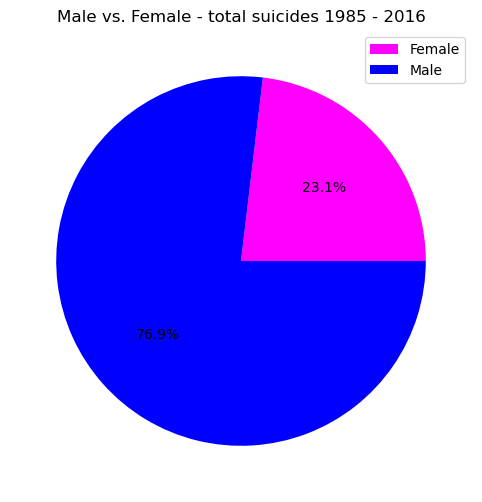

In [21]:
plt.pie(male_female_suicides, colors= ["magenta", "blue"], autopct="%1.1f%%")
plt.legend(labels = ["Female", "Male"], loc = "upper right")
plt.title("Male vs. Female - total suicides 1985 - 2016")
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

This seems legit. The statistic information on an official website for suicide prevention(https://save.org/about-suicide/suicide-statistics/) tells us that "There are 3.9 male deaths by suicide for each female death by suicide.", which corresponds to the data on my visualisation.<br>
##### 2.3.2 Suicides per country

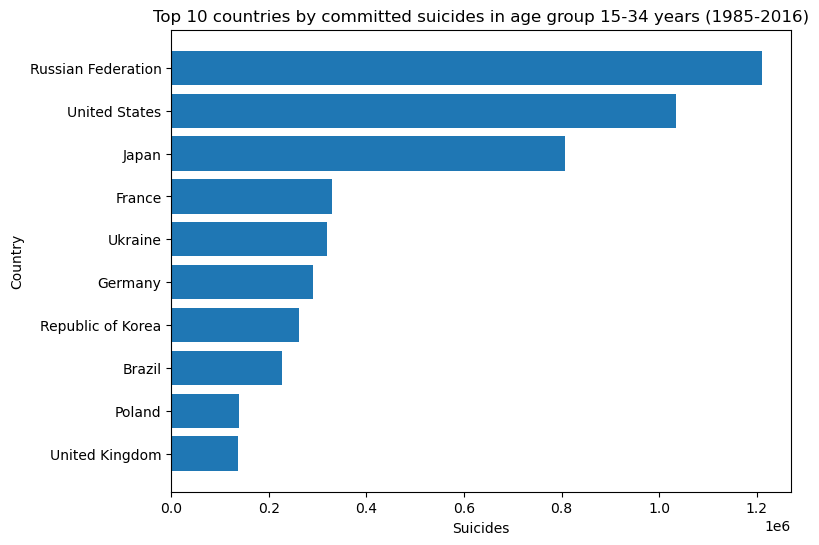

In [22]:
labels =suicide_data_world.suicides_no.groupby(suicide_data_world.country).sum().nlargest(10).sort_values().index.tolist()
data = suicide_data_world.suicides_no.groupby(suicide_data_world.country).sum().nlargest(10).sort_values().tolist()

plt.figure(figsize=(8,6))
plt.barh(labels, data)
plt.title("Top 10 countries by committed suicides in age group 15-34 years (1985-2016)")
plt.xlabel("Suicides")
plt.ylabel("Country")
plt.show()

Wow, this looks pretty surprisingly for me. I have expected, that Russian Federation and Korea are somewhere there at the top, but we can find Japan, USA, Germany, France and UK in the top 10. Those are one of the best developed countries in the world and offer really high standard and very good life quality. Well, it is true, that they are also very populated, but Germany is still a surprise for me there. <br>

The population matters definitely and thats why I want to use the ```suicides_per_100k``` column to visualise the same graph and see whether something will change. I will take the mean value for all of the years.

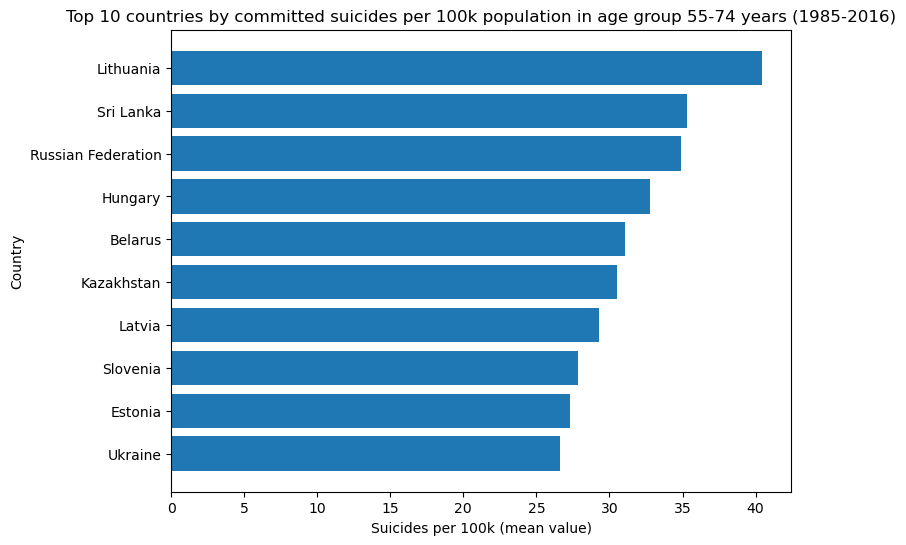

In [23]:
labels = suicide_data_world.suicides_per_100k.groupby(suicide_data_world.country).mean().nlargest(10).sort_values().index.tolist()
data = suicide_data_world.suicides_per_100k.groupby(suicide_data_world.country).mean().nlargest(10).sort_values().tolist()

plt.figure(figsize=(8,6))
plt.barh(labels, data)
plt.title("Top 10 countries by committed suicides per 100k population in age group 55-74 years (1985-2016)")
plt.xlabel("Suicides per 100k (mean value)")
plt.ylabel("Country")
plt.show()

Wow, this changed my previos result completely. Only Ukraine and Russa Federation are still here and what attract my attention is that there are a lot of countries from the USSR. Our data is 1985 till 2016 and some of the data corresponds the years when those countries were still in the USSR. For sure, this is pretty interesting, as we suspect (know) how kills are qualified as suicides in these countries. This definitely biases our data. <br>
However, if I want to compare what a value of 30-40 cases per 100k people means, I can check the mean value for all the countries in all the years (complete dataset) and see what value I will get:

In [24]:
suicides_55_to_74_years = suicide_data_world[suicide_data_world["age"]=="55-74 years"]

In [25]:
suicides_55_to_74_years.suicides_per_100k.mean()

16.155579491598463

In [26]:
suicides_55_to_74_years.suicides_per_100k.groupby(suicides_55_to_74_years.country).mean().nlargest(10).mean()

42.10508847171347

Well, it might be useful to check out each of there countries individually, but as I mentioned, the data there is definitely not completely real. I will take Germany for my furhter work, because this is (one of) the best developed country not only in Europe, but also in the whole world.

#### 3. Suicide data - focus on Germany

##### 3.1 Data acquisition and Data familiarisation


In [27]:
suicide_data_germany = suicide_data_world[suicide_data_world.country == "Germany"]

In [28]:
suicide_data_germany.shape

(312, 10)

In [29]:
suicide_data_germany.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 9710 to 10021
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             312 non-null    object 
 1   year                312 non-null    int64  
 2   sex                 312 non-null    object 
 3   age                 312 non-null    object 
 4   suicides_no         312 non-null    int64  
 5   population          312 non-null    int64  
 6   suicides_per_100k   312 non-null    float64
 7   gdp_for_year_usd    312 non-null    object 
 8   gdp_per_capita_usd  312 non-null    int64  
 9   generation          312 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 26.8+ KB


Ok, as expected, no missing values, columns look good, we already did our job so the only think I want to make is to drop the columns ```country```,```population```,```gdp_for_year_usd``` and ```gdp_per_capita_usd```. The reason for this is that we have only 1 unique value for country - Germany, and the data about the population and gdp is not needed, because we will not compare with other countries based on gdp or population. We still have the ```suicides_per_100k``` column which is enough.<br>
##### 3.2 Data tidying and cleaning<br>

In [30]:
suicide_data_germany = suicide_data_germany.drop(columns = ["country","population", "gdp_for_year_usd", "gdp_per_capita_usd"], axis = 1)

In [31]:
suicide_data_germany.head(15)

,year,sex,age,suicides_no,suicides_per_100k,generation
9710,1990,male,75+ years,1516,88.26,G.I. Generation
9711,1990,male,55-74 years,2406,36.49,G.I. Generation
9712,1990,male,35-54 years,3302,29.68,Silent
9713,1990,female,75+ years,1174,29.51,G.I. Generation
9714,1990,male,15-34 years,1488,22.14,Boomers
9715,1990,female,55-74 years,1417,16.60,G.I. Generation
9716,1990,male,15-34 years,800,14.37,Generation X
9717,1990,female,35-54 years,1128,10.50,Silent
9718,1990,female,15-34 years,434,6.86,Boomers
9719,1990,female,15-34 years,228,4.31,Generation X


Perfect, now it looks much better and we can start with the visualisations.
#### 3.3 Data visualization<br>
##### 3.3.1 Male vs. Female<br>

In [32]:
male_female_suicides_germany = suicide_data_germany.suicides_no.groupby(suicide_data_germany.sex).sum()

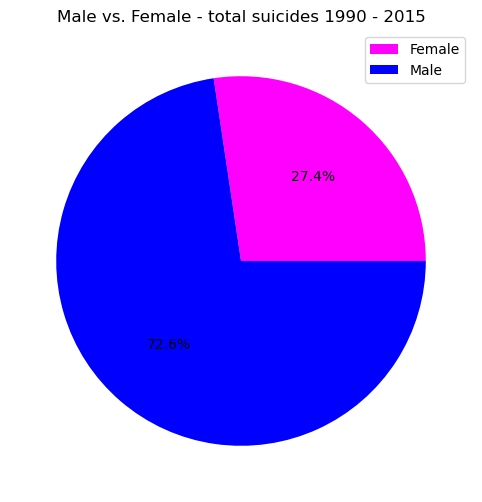

In [33]:
plt.pie(male_female_suicides_germany, colors= ["magenta", "blue"], autopct="%1.1f%%")
plt.legend(labels = ["Female", "Male"], loc = "upper right")
plt.title("Male vs. Female - total suicides 1990 - 2015")
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [34]:
def male_female_visualization_data(dataset, year):
    return dataset[dataset.year== year].suicides_no.groupby(dataset.sex).sum()

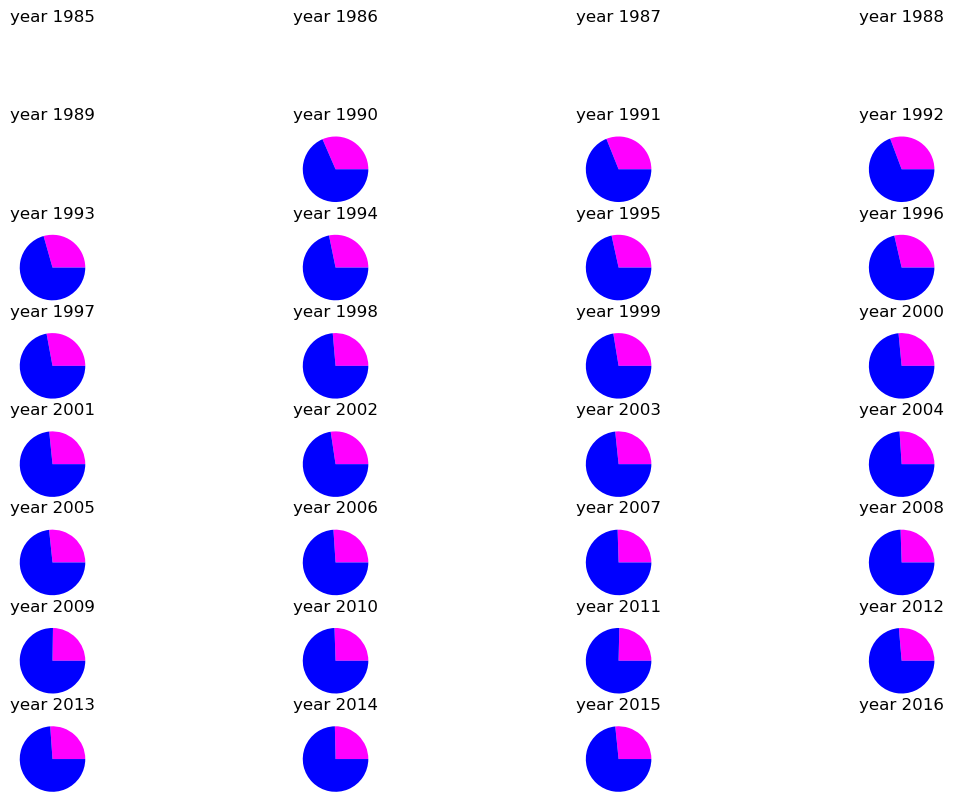

In [35]:
fig, axs = plt.subplots(8,4, figsize=(14,10))
axs = axs.ravel()

for i in range(0,32):
    axs[i].pie(male_female_visualization_data(suicide_data_germany,1985+i), colors= ["magenta", "blue"])
    axs[i].title.set_text(f"year {1985+i}")
plt.show()

Ok, it looks almost the same for all the years. We do not have any year with anomaly that differs a lot from the "mean". However, I see that there is no data for the years 1985, 1986, 1987, 1988, 1989 and 2016. Now I want to group my data by age group and check the sex correlation then for the different age groups.

In [36]:
age_groups = suicide_data_germany.age.unique()

In [37]:
def filter_age_groups(dataset, condition):
    return dataset[dataset.age == condition].suicides_no.groupby(dataset.sex).sum()

In [38]:
def create_pie_chart(dataset, condition):
    plt.pie(filter_age_groups(dataset, condition), colors= ["magenta", "blue"], autopct="%1.1f%%")
    plt.legend(labels = ["Female", "Male"], loc = "upper right")
    plt.title(f"Male vs. Female - total suicides 1990 - 2015 ({condition})")
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    plt.show()

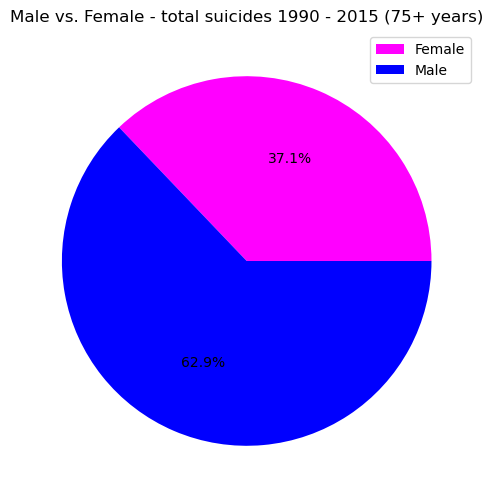

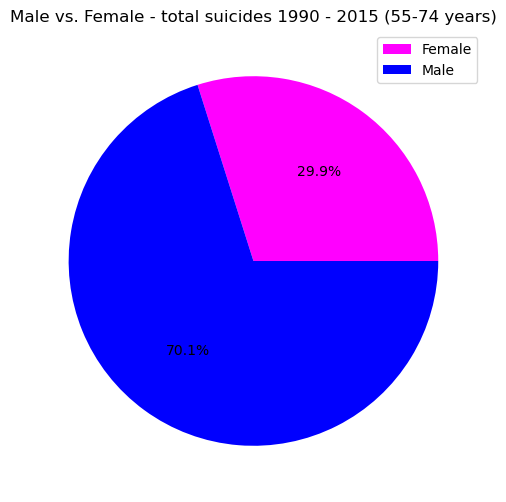

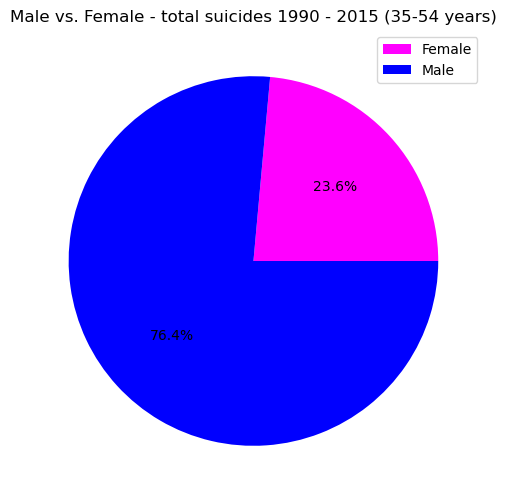

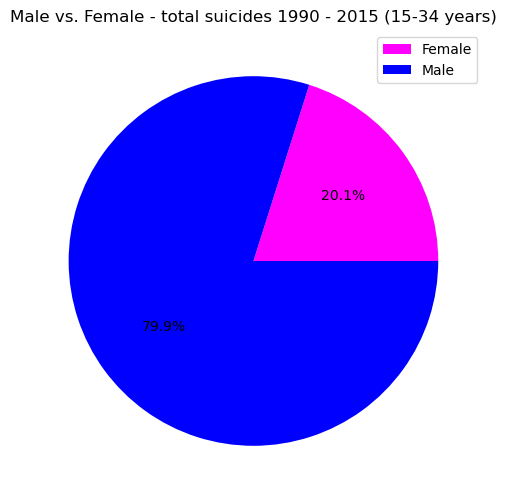

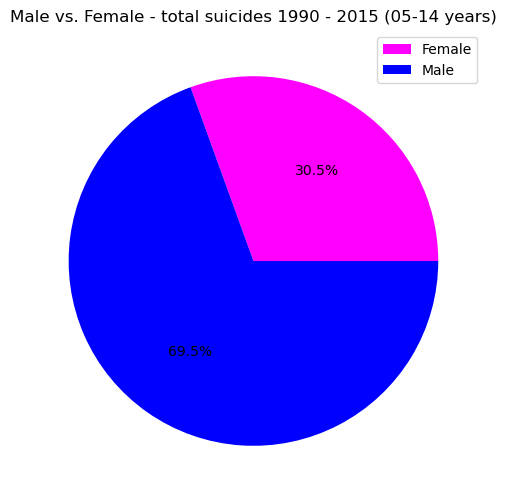

In [39]:
for age_group in age_groups:
    create_pie_chart(suicide_data_germany, age_group)

Hm, male suicides dominate as usual, but in the very young and very old group I can see that female share rises. At the 75+ group I can explain this as there are more elderly women than men.

Ok, lets see how it looks like in the different age groups. Here we can expect that the cases top at ```35-54 years``` age group, but the ```15-34 years``` and ```55-74 years``` also have relatively high values.

##### 3.3.2 Age group distribution

In [40]:
suicide_data_germany.suicides_no.groupby(suicide_data_germany.age).sum()

age
05-14 years      832
15-34 years    50849
35-54 years    97833
55-74 years    89191
75+ years      52557
Name: suicides_no, dtype: int64

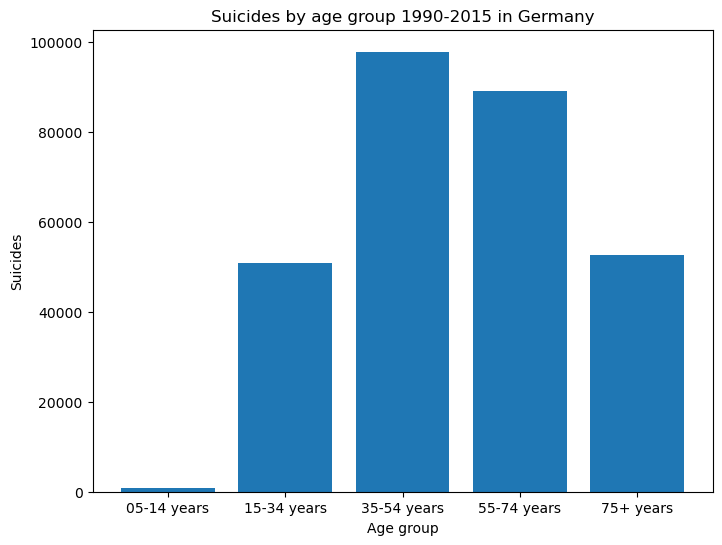

In [41]:
labels = suicide_data_germany.suicides_no.groupby(suicide_data_germany.age).sum().index.tolist()
data = suicide_data_germany.suicides_no.groupby(suicide_data_germany.age).sum().tolist()

plt.figure(figsize=(8,6))
plt.bar(labels, data)
plt.title("Suicides by age group 1990-2015 in Germany")
plt.xlabel("Age group")
plt.ylabel("Suicides")
plt.show()

Pretty close to my expectations, but I can see that the ```15-34 years``` age group looks better in comparison to the world (total), but the ```75+ years``` looks worse. I want to see how it is if we take the mean value of ```suicides_per_100k``` in the different age groups:

In [42]:
suicide_data_germany.suicides_per_100k.groupby(suicide_data_germany.age).mean()

age
05-14 years     0.375192
15-34 years     8.875769
35-54 years    15.691923
55-74 years    19.486923
75+ years      40.053846
Name: suicides_per_100k, dtype: float64

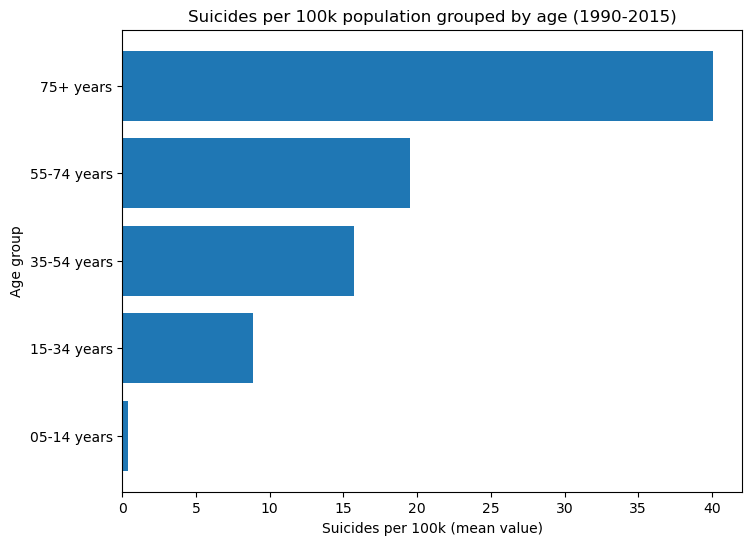

In [43]:
labels = suicide_data_germany.suicides_per_100k.groupby(suicide_data_germany.age).mean().index.tolist()
data = suicide_data_germany.suicides_per_100k.groupby(suicide_data_germany.age).mean().tolist()

plt.figure(figsize=(8,6))
plt.barh(labels, data)
plt.title("Suicides per 100k population grouped by age (1990-2015)")
plt.xlabel("Suicides per 100k (mean value)")
plt.ylabel("Age group")
plt.show()

Wow, this was interesting. 75+ years old people in Germany look like really risky group and are very prone to commit a suicide.Lets see how does it look like in comparison to the world data:

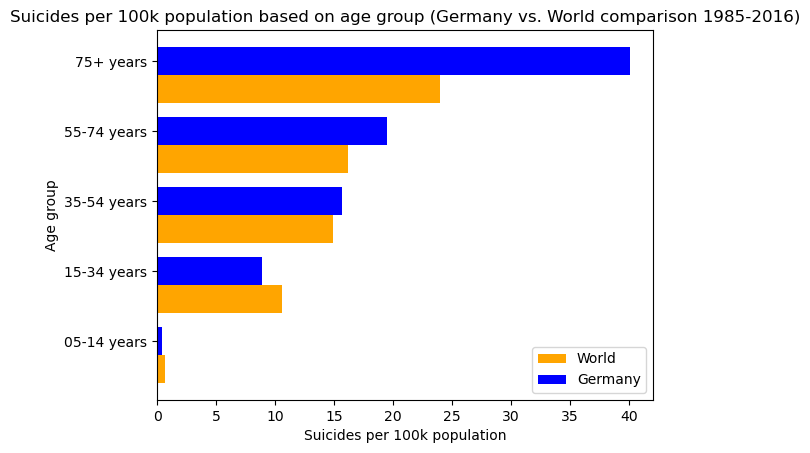

In [44]:
labels = suicide_data_world.suicides_per_100k.groupby(suicide_data_world.age).mean().index.tolist()
data = suicide_data_world.suicides_per_100k.groupby(suicide_data_world.age).mean().tolist()
data2 = suicide_data_germany.suicides_per_100k.groupby(suicide_data_germany.age).mean().tolist()

width = 0.4
ind = np.array([0, 1, 2, 3, 4])

fig, ax = plt.subplots()
ax.barh(ind, np.array(data), width, color='orange', label="World")
ax.barh(ind+width, np.array(data2), width, color='blue', label="Germany")
ax.set(yticks=ind+width, yticklabels=labels)
ax.legend(loc="lower right")
plt.title("Suicides per 100k population based on age group (Germany vs. World comparison 1985-2016)")
plt.xlabel("Suicides per 100k population")
plt.ylabel("Age group")

plt.show()

Well, ```75+ years``` age group is still catching my attentin. The other age groups look near to the world mean. What more I would like to check is the distribution grouped by generation.

##### 3.3.3 Generation

In [45]:
suicide_data_germany.suicides_no.groupby(suicide_data_germany.generation).sum().sort_values()

generation
Generation Z          196
Millenials          14094
G.I. Generation     27249
Generation X        47356
Boomers             99684
Silent             102683
Name: suicides_no, dtype: int64

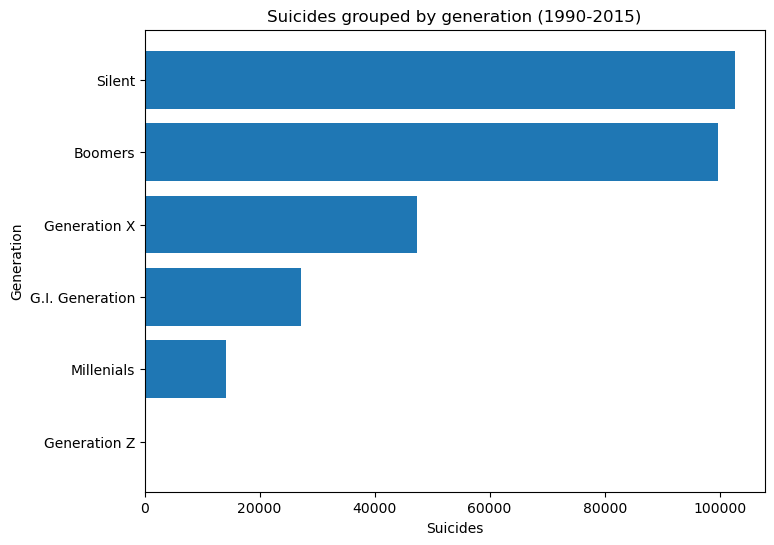

In [46]:
labels = suicide_data_germany.suicides_no.groupby(suicide_data_germany.generation).sum().sort_values().index.tolist()
data = suicide_data_germany.suicides_no.groupby(suicide_data_germany.generation).sum().sort_values().tolist()

plt.figure(figsize=(8,6))
plt.barh(labels, data)
plt.title("Suicides grouped by generation (1990-2015)")
plt.xlabel("Suicides")
plt.ylabel("Generation")
plt.show()

Hm, they seem very good sorted starting from older people and getting to younger generations. The only generation that is not placed "correctly" is the G.I Generation (oldest one). I suppose there are just not so many cases, because there are very few people alive. Lets see how does it look like if we take the ```suicides_per_100k``` column.

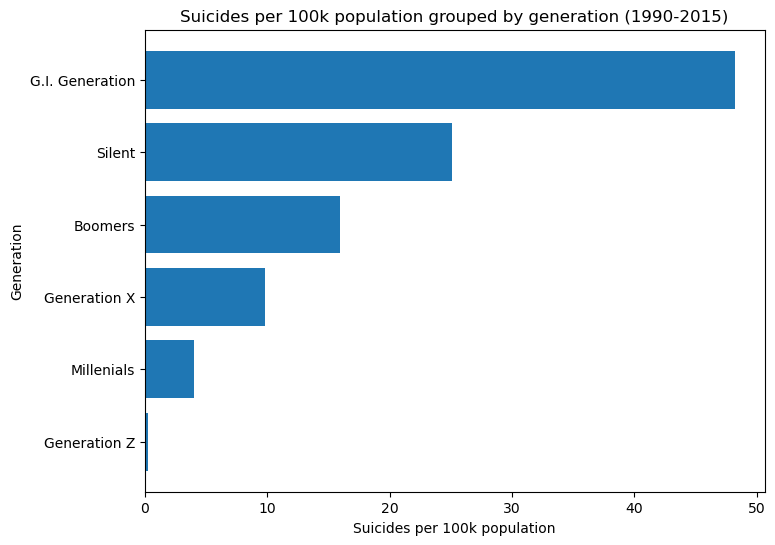

In [47]:
labels = suicide_data_germany.suicides_per_100k.groupby(suicide_data_germany.generation).mean().sort_values().index.tolist()
data = suicide_data_germany.suicides_per_100k.groupby(suicide_data_germany.generation).mean().sort_values().tolist()

plt.figure(figsize=(8,6))
plt.barh(labels, data)
plt.title("Suicides per 100k population grouped by generation (1990-2015)")
plt.xlabel("Suicides per 100k population")
plt.ylabel("Generation")
plt.show()

Ok, now it is definitely sorted perfectly starting from the oldes generation and going to the youngest one. 

##### 3.3.4 Year distribution

In [48]:
suicides_over_years_germany = suicide_data_germany.suicides_no.groupby(suicide_data_germany.year).sum()

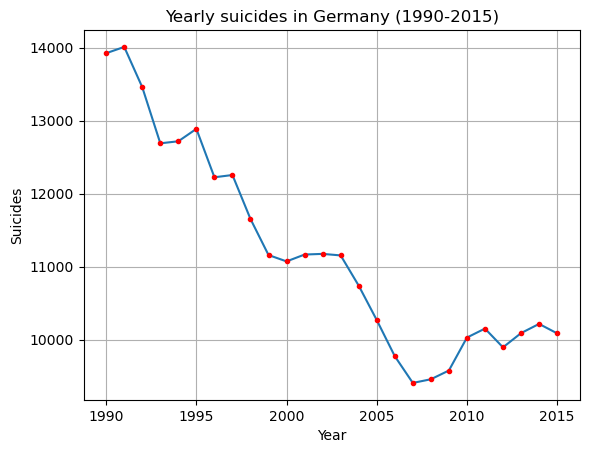

In [49]:
plt.plot(suicides_over_years_germany, marker = ".", mfc = "red",  mec = "red")
plt.title("Yearly suicides in Germany (1990-2015)")
plt.xlabel("Year")
plt.ylabel("Suicides")
plt.grid()

plt.show()

Definitely a very nice downtrend since 1990. The last 10 years in the timespan 2005-2015 there is some increase in the suicide cases, but no dramatic changes. I really want to find out how the people commit a suicide, so I will need another dataset with information about it. I managed to find only one dataset with raw data that will help me. Unfortunately the dataset is very old (1979), but I will compare the results after that with the government information system of Germany for recent years (The data there is not raw, but structured and cleaned).

#### 4. West Germany Suicide

##### 4.1 Data acquisition and Data familiarisation

In [50]:
suicide_data_west_germany = pd.read_csv("data/Suicide West Germany.csv", index_col= 0)

Here is the description of the columns:<br>

```Freq``` -> frequency of suicides<br>
```sex``` -> factor indicating sex (male, female)<br>
```method``` -> factor indicating method used. (poison, cookgas, toxicgas, hang, drown)<br>
```age``` -> age (rounded)<br>
```age.group``` -> factor. Age classified into 5 groups<br>
```method2``` -> factor indicating method used (same as method but some levels are merged)<br>

In [51]:
suicide_data_west_germany.shape

(306, 6)

In [52]:
suicide_data_west_germany.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 1 to 306
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Freq       306 non-null    int64 
 1   sex        306 non-null    object
 2   method     306 non-null    object
 3   age        306 non-null    int64 
 4   age.group  306 non-null    object
 5   method2    306 non-null    object
dtypes: int64(2), object(4)
memory usage: 16.7+ KB


In [53]:
suicide_data_west_germany.sex.unique()

array(['male', 'female'], dtype=object)

In [54]:
suicide_data_west_germany.age.unique()

array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
      dtype=int64)

In [55]:
suicide_data_west_germany["age.group"].unique()

array(['10-20', '25-35', '40-50', '55-65', '70-90'], dtype=object)

In [56]:
suicide_data_west_germany

,Freq,sex,method,age,age.group,method2
1,4,male,poison,10,10-20,poison
2,0,male,cookgas,10,10-20,gas
3,0,male,toxicgas,10,10-20,gas
4,247,male,hang,10,10-20,hang
5,1,male,drown,10,10-20,drown
...,...,...,...,...,...,...
302,4,female,drown,90,70-90,drown
303,0,female,gun,90,70-90,gun
304,2,female,knife,90,70-90,knife
305,7,female,jump,90,70-90,jump


In [57]:
suicide_data_west_germany.method.unique()

array(['poison', 'cookgas', 'toxicgas', 'hang', 'drown', 'gun', 'knife',
       'jump', 'other'], dtype=object)

In [58]:
suicide_data_west_germany.method2.unique()

array(['poison', 'gas', 'hang', 'drown', 'gun', 'knife', 'jump', 'other'],
      dtype=object)

Ok, pretty small dataset with frequency records. It is also relatively clean - has no null values, has appropriate datatypes in the columns. 2 small things that I want to correct are to reorder the columns so that method and method 2 are one next to the other. And the second thing is to change the name of the column "Freq" to "freqency" and "age.group" to "age_group".
##### 4.2 Data tidying and cleaning<br>

In [59]:
suicide_data_west_germany = suicide_data_west_germany[["Freq", "sex", "age", "age.group", "method", "method2"]]

In [60]:
suicide_data_west_germany.rename(columns={"Freq":"frequency", "age.group":"age_group"}, inplace = True)

In [61]:
suicide_data_west_germany.head(5)

,frequency,sex,age,age_group,method,method2
1,4,male,10,10-20,poison,poison
2,0,male,10,10-20,cookgas,gas
3,0,male,10,10-20,toxicgas,gas
4,247,male,10,10-20,hang,hang
5,1,male,10,10-20,drown,drown


Another interesting thing is that the age group is not complete. There are ages which are not represented. For this reason, I will create a new column based on multiple conditions in the column ```age```. Then I will drop te old age_group column.

In [62]:
conditions = [
    (suicide_data_west_germany.age <= 14),
    (suicide_data_west_germany.age > 14) & (suicide_data_west_germany.age <= 34),
    (suicide_data_west_germany.age > 34) & (suicide_data_west_germany.age <= 54),
    (suicide_data_west_germany.age > 54) & (suicide_data_west_germany.age <= 74),
    (suicide_data_west_germany.age > 74)
    ]

values = ["05-14 years", "15-34 years", "35-54 years", "55-74 years", "75+ years"]
suicide_data_west_germany["age_group_new"] = np.select(conditions, values)

suicide_data_west_germany.head()

,frequency,sex,age,age_group,method,method2,age_group_new
1,4,male,10,10-20,poison,poison,05-14 years
2,0,male,10,10-20,cookgas,gas,05-14 years
3,0,male,10,10-20,toxicgas,gas,05-14 years
4,247,male,10,10-20,hang,hang,05-14 years
5,1,male,10,10-20,drown,drown,05-14 years


In [63]:
suicide_data_west_germany.drop(columns = "age_group", inplace = True)

Perfect, now lets analyse the data and visualise it.
##### 4.3 Data visualization<br>
##### 4.3.1 Suicide method distribution<br>

Ok, first I want to see the distribution of the suicides commited grouped by method and after that I would like to do the same for males and females.

In [64]:
suicides_grouped_by_method = suicide_data_west_germany.frequency.groupby(suicide_data_west_germany.method).sum()

In [65]:
suicides_grouped_by_method

method
cookgas       253
drown        2649
gun          3118
hang        20377
jump         2845
knife         937
other        3284
poison      17565
toxicgas     2154
Name: frequency, dtype: int64

In [66]:
suicides_grouped_by_method/suicide_data_west_germany.frequency.sum()*100

method
cookgas      0.475725
drown        4.981009
gun          5.862886
hang        38.315596
jump         5.349554
knife        1.761874
other        6.175022
poison      33.028092
toxicgas     4.050243
Name: frequency, dtype: float64

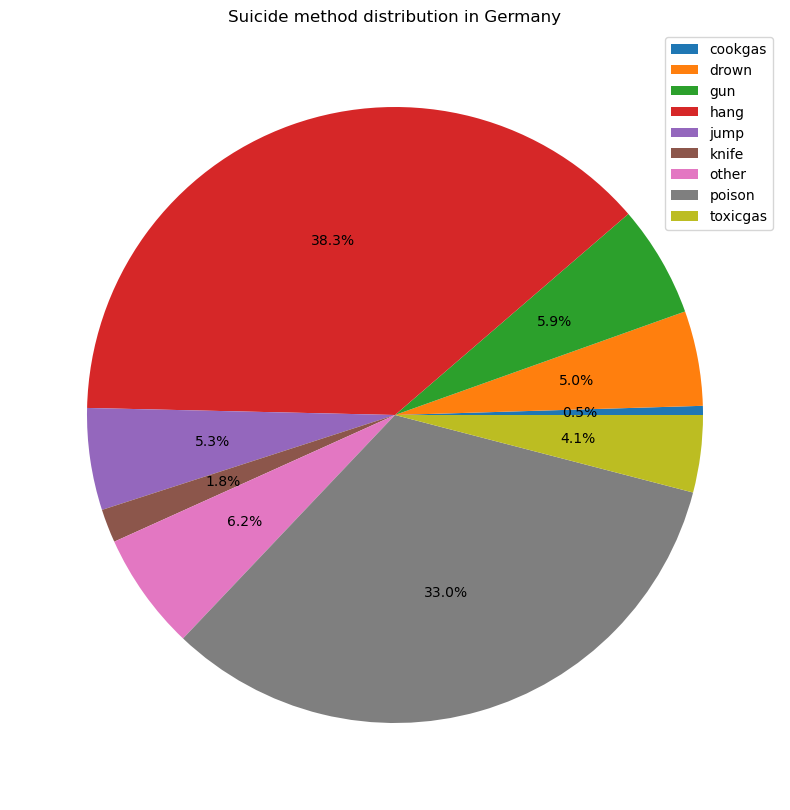

In [67]:
plt.pie(suicides_grouped_by_method, autopct="%1.1f%%")
plt.legend(labels = suicides_grouped_by_method.index, loc = "upper right")
plt.title("Suicide method distribution in Germany")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [68]:
suicide_data_west_germany_male = suicide_data_west_germany[suicide_data_west_germany.sex == "male"]
suicide_data_west_germany_female = suicide_data_west_germany[suicide_data_west_germany.sex == "female"]

In [69]:
suicides_grouped_by_method_male = suicide_data_west_germany_male.frequency.groupby(suicide_data_west_germany_male.method).sum()
suicides_grouped_by_method_female = suicide_data_west_germany_female.frequency.groupby(suicide_data_west_germany_female.method).sum()

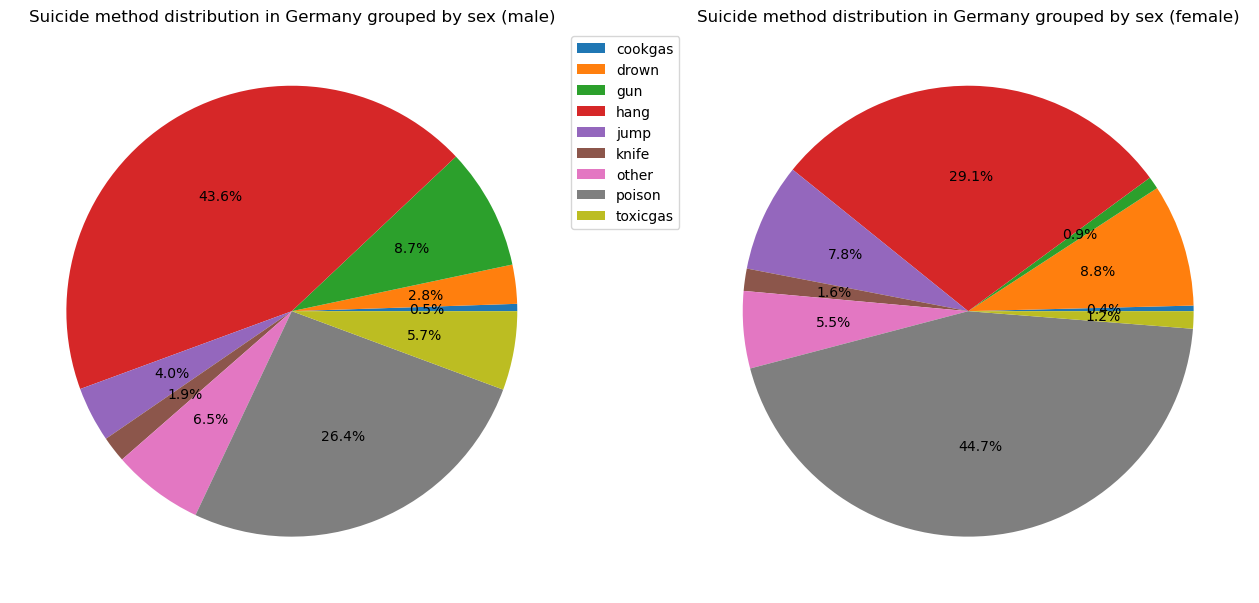

In [70]:
fig = plt.figure(figsize=(16,10))

ax1 = plt.subplot2grid((1,2),(0,0))
plt.pie(suicides_grouped_by_method_male, autopct="%1.1f%%")
plt.title("Suicide method distribution in Germany grouped by sex (male)")

ax1 = plt.subplot2grid((1, 2), (0, 1))
plt.pie(suicides_grouped_by_method_female, autopct="%1.1f%%")
plt.title("Suicide method distribution in Germany grouped by sex (female)")
plt.legend(labels = suicides_grouped_by_method.index, bbox_to_anchor=(-0, 1))
plt.show()

Hmm ok, it looks like male and female prefer different method for committing a suicide. I found some statistics about the same topic from recent years (2004-2005). THe data is not raw, but I want just to compare whether people in Germany still use the same methods or there is some difference. And it looks pretty similar<br>

source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2569832/

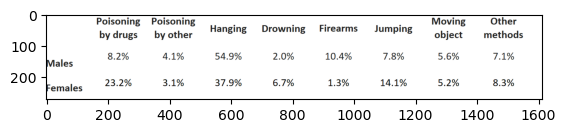

In [71]:
suicide_method_image = imread("data/Suicide methods by sex.PNG")
plt.imshow(suicide_method_image)
plt.show()

I will now first extract the data from the image using ```tesseract``` and will then visualise the data again in a pie chart.

In [72]:
suicide_methods_germany = ""
with open ("data/suicide-methods.txt", "r", encoding = "utf-8") as f:
    suicide_methods_germany = f.read()
print(suicide_methods_germany)

Sex,Poisoning by drugs,Poisoning by drugs,Hanging,Drowning,Firearms,Jumping,Moving object,Other methods

Males,8.2%,4.1%,54.9%,2.0%,10.4%,7.8%,5.6%,7.1%

Females,23.2%,3.1%,37.9%,6.7%,1.3%,14.1%,5.2%,8.3%


In [73]:
def generate_table(string):
    data = [text.split(",") for text in string.split("\n\n")]
    return data

In [74]:
generate_table(suicide_methods_germany)

[['Sex',
  'Poisoning by drugs',
  'Poisoning by drugs',
  'Hanging',
  'Drowning',
  'Firearms',
  'Jumping',
  'Moving object',
  'Other methods'],
 ['Males', '8.2%', '4.1%', '54.9%', '2.0%', '10.4%', '7.8%', '5.6%', '7.1%'],
 ['Females',
  '23.2%',
  '3.1%',
  '37.9%',
  '6.7%',
  '1.3%',
  '14.1%',
  '5.2%',
  '8.3%']]

In [75]:
suicide_methods_germany = pd.DataFrame(generate_table(suicide_methods_germany))
suicide_methods_germany.columns = suicide_methods_germany.iloc[0]
suicide_methods_germany.drop(suicide_methods_germany.index[0], inplace = True)
suicide_methods_germany.set_index(["Sex"], inplace = True)

In [76]:
suicide_methods_germany

,Poisoning by drugs,Poisoning by drugs,Hanging,Drowning,Firearms,Jumping,Moving object,Other methods
Sex,,,,,,,,
Males,8.2%,4.1%,54.9%,2.0%,10.4%,7.8%,5.6%,7.1%
Females,23.2%,3.1%,37.9%,6.7%,1.3%,14.1%,5.2%,8.3%


Ok I managed to extract the information and create a table from the image. I can also see that the methods used for committing a suicide and its distribution are very similar almost 30 years later. This is interesting, but I will not research this topic further. I am rather interested to see the age groups now and its distribution:

##### 4.3.2 Age group distribution<br>

In [77]:
suicide_data_west_germany.age.unique()

array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
      dtype=int64)

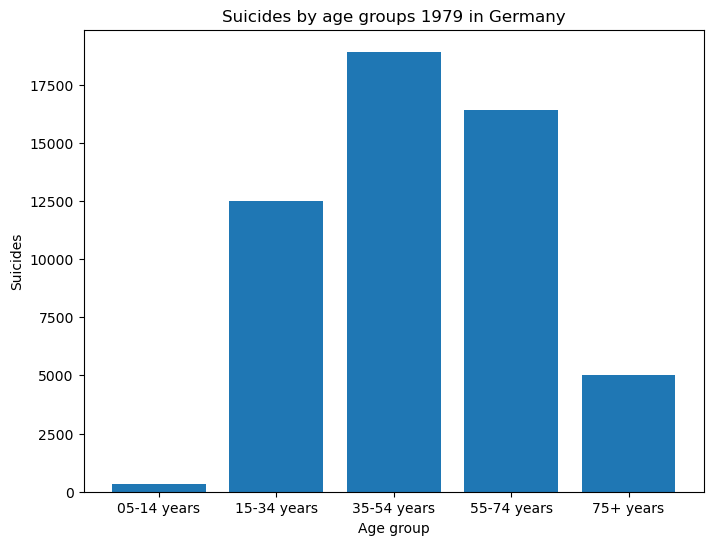

In [78]:
labels = suicide_data_west_germany.frequency.groupby(suicide_data_west_germany.age_group_new).sum().index.tolist()
data = suicide_data_west_germany.frequency.groupby(suicide_data_west_germany.age_group_new).sum().tolist()

plt.figure(figsize=(8,6))
plt.bar(labels, data)
plt.title("Suicides by age groups 1979 in Germany")
plt.xlabel("Age group")
plt.ylabel("Suicides")
plt.show()

In [79]:
data1 = suicide_data_west_germany_male.frequency.groupby(suicide_data_west_germany_male.age_group_new).sum().tolist()
data2 = suicide_data_west_germany_female.frequency.groupby(suicide_data_west_germany_female.age_group_new).sum().tolist()
labels = labels = suicide_data_west_germany_male.frequency.groupby(suicide_data_west_germany_male.age_group_new).sum().index.tolist()

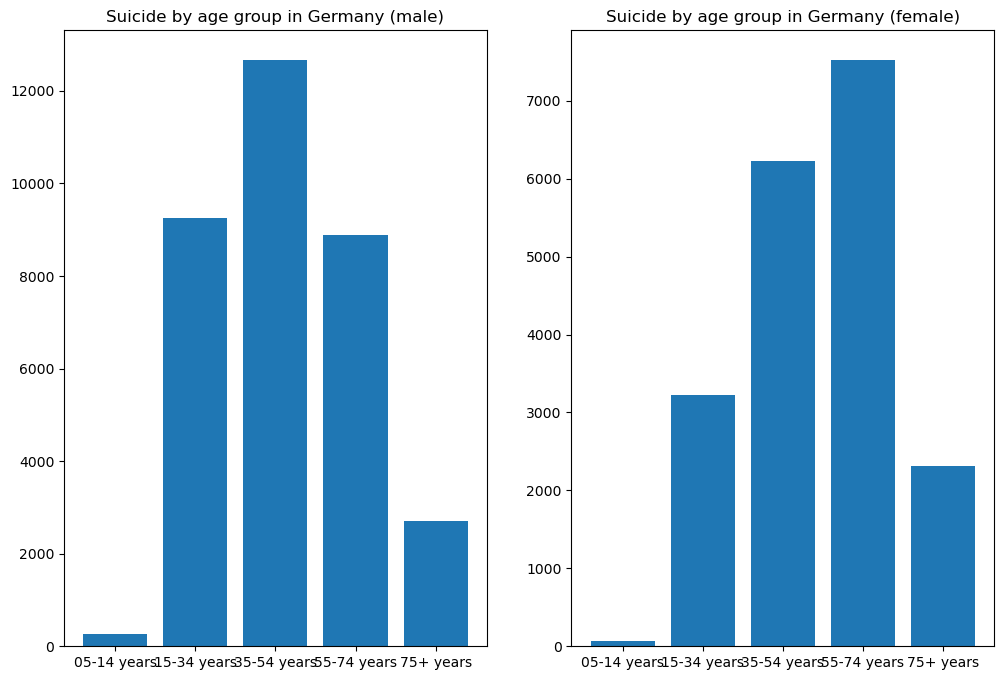

In [80]:
fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((1,2),(0,0))
plt.bar(labels, data1)
plt.title("Suicide by age group in Germany (male)")

ax1 = plt.subplot2grid((1, 2), (0, 1))
plt.bar(labels, data2)
plt.title("Suicide by age group in Germany (female)")
plt.show()

Well, this looks interesting. It looks like men are prone to commit a suicide rather in their Prime time and women do it at later stage. It is definitely interesting to find out how and at what point people take the decision. Is there anything that can be done to avoid the suicide. Do they "prepare" their families and friends? Well, I found a dataset that consists of text messages of people. Some of them comitted after that a suicide and others did not. I will first prepare the data and then create a model trying to predict whether a person is prone to commit a suicide based on his text messages.

#### 5. Suicide detection per text message<br>
##### 5.1 Data acquisition and Data familiarisation<br>

Data can be found here:
https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch?select=Suicide_Detection.csv

Unfortunately, the dataset is too large so I can not upload it alltogether.

In [81]:
suicide_text_messages = pd.read_csv("data/Suicide_Detection_text_messages.csv")
suicide_text_messages.head(5)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [82]:
suicide_text_messages.shape

(232074, 3)

In [83]:
suicide_text_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


Well, we have in total 3 columns, but I will need to do some work to prepare them for modeling. First, I will drop the column ```0``` and leave the standard column for indexes, because the original column ```0``` skips some numbers. After that I will deplace the values in ```class``` column replacing the actual values with 0 and 1.

##### 5.2 Data tidying and cleaning

In [84]:
suicide_text_messages.drop(columns=["Unnamed: 0"], axis=1, inplace = True)

In [85]:
suicide_text_messages["class"] = suicide_text_messages["class"].replace(["suicide", "non-suicide"],[1,0])
suicide_text_messages.head(5)

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


Ok, now it looks like my dataset is tidy and ready for modelling. I will first extract all the messages in a separate list so that i can train my model after that.

In [86]:
text_messages_list = suicide_text_messages.text.values.tolist()

In [87]:
#to see all symbols and letters
#Counter("\n".join(text_messages_list)).most_common()

#to see just a few, because there are a lot of symbols, letters, emoticons etc.
Counter("\n".join(text_messages_list)).most_common(30)

[(' ', 30296434),
 ('e', 14136215),
 ('t', 11078331),
 ('o', 9392384),
 ('a', 9160217),
 ('n', 8417606),
 ('i', 7806413),
 ('s', 7047612),
 ('h', 5825421),
 ('r', 5607636),
 ('l', 5498437),
 ('d', 4829961),
 ('m', 3843995),
 ('u', 3458538),
 ('y', 3325314),
 ('g', 2851306),
 ('f', 2604624),
 ('w', 2591246),
 ('c', 2530259),
 ('I', 2200596),
 ('p', 2084808),
 ('.', 2001141),
 ('b', 1904150),
 ('k', 1452354),
 ('v', 1445285),
 (',', 1041034),
 ('\n', 1025020),
 ("'", 872050),
 ('j', 343776),
 ('’', 343258)]

Nice, the Counter showed us the known system Etaoin shrdlu and the letters from our messages coincide very good with it. Ok, I will use now the TF-IDF in order to fit my data. I am also adding an additional setting for the ngram range, so that I get not just the separate words, but also all the expressions with up to 4 words in it.
#### 6. Modeling<br>
##### 6.1 Model training<br>

In [88]:
tfidf = TfidfVectorizer(ngram_range=(1,4))

In [89]:
X = tfidf.fit_transform(text_messages_list)

In [90]:
y = suicide_text_messages["class"].tolist()

Perfect, now I fit the data and want to check the vocabulury to be sure that expressions with up to 4 words are also in it.

In [91]:
tfidf.vocabulary_

{'ex': 8932501,
 'wife': 32688713,
 'threatening': 29172187,
 'suiciderecently': 26586718,
 'left': 16077277,
 'my': 18625669,
 'for': 9880418,
 'good': 11250237,
 'because': 3915763,
 'she': 24652799,
 'has': 11942607,
 'cheated': 5748364,
 'on': 20856308,
 'me': 17422399,
 'twice': 30640346,
 'and': 1543050,
 'lied': 16190433,
 'to': 29432223,
 'so': 25281785,
 'much': 18513446,
 'that': 27099027,
 'have': 12059295,
 'decided': 7007224,
 'refuse': 23546282,
 'go': 11069891,
 'back': 3480548,
 'her': 12664875,
 'as': 2999723,
 'of': 20242253,
 'few': 9579181,
 'days': 6893131,
 'ago': 864685,
 'began': 4204716,
 'suicide': 26537827,
 'tirelessly': 29418965,
 'spent': 25907590,
 'these': 28463977,
 'paat': 21842011,
 'talking': 26841524,
 'out': 21597768,
 'it': 14718247,
 'keeps': 15589210,
 'hesitating': 12862338,
 'wants': 31531391,
 'believe': 4312686,
 'll': 16726576,
 'come': 6041916,
 'know': 15749826,
 'lot': 16957579,
 'people': 22114338,
 'will': 32701088,
 'threaten': 291703

Looks got. Now I want to test my model and see how accurate is it. I will use the Bernoulli Naive Bayes for a classificator, because my target values are binary (0 and 1).

In [92]:
text_classifier = BernoulliNB()

So first I will fit the data:

In [93]:
text_classifier.fit(X,y)

BernoulliNB()

Then I will use the fitted model to predict tha same data based on what it has learnt:

In [94]:
predictions = text_classifier.predict(X)

Now we have already the predicted data and can measure the accuracy score of our model to check how many messages were correctly predicted:
##### 6.2 Model results<br>

In [95]:
print(accuracy_score(y, predictions))

0.7882658117669364


Well, this is a good score, however we need to consider the fact that I did not split the dataset into train and test data. Doing this, the score should decrease, trying to predict new (unseen) data. I want to check the classification report for more details:

In [96]:
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.71      0.99      0.82    116037
           1       0.98      0.59      0.74    116037

    accuracy                           0.79    232074
   macro avg       0.84      0.79      0.78    232074
weighted avg       0.84      0.79      0.78    232074



Hm, interesting, we do have 98% precision for suicides, which means that 98% from the predicted suicides are true, but in the same time we have only 59% reccall, which means that 59% of the actual suicides were correctly predicted and the rest was missed. This is actually not very satisfying, because we miss too much potential suicides.

In [97]:
print(confusion_matrix(y, predictions))

[[114741   1296]
 [ 47842  68195]]


Well I have 114741 correctly predictes 0 and 68195 correctly predicted 1. Furthermore, I see 1296 predicted for suicides, but there we did not have suicide. The biggest problem however is that I have 47842 cases that my model predicted "no suicide" and the person commited a suicide. This is extremely bad for my model, because this is the most important metric in this case.

#### 7. Limitations and further improvements<br>
In this project I used only one classificator, did not use train and test data and used only one dataset with constrained information for training my model (only text message).<br>
Well, there is a lot of work to be done so that such a model is created which can successfully predict potential suicide cases.
First of all some more data can be definitely a good idea so that the model can be trained better. After that the data should be splitted into train and test data when the model is beeing created so that the model can predict new/unseen data. Of course, there might be also a better option for a classificator which should be tested for better results.<br>
The benefit of such a model will definitely be large, because a lot of young people end their lifes too early, without showing their potential. If such people can be successfully identified and helped, the world shoud get a better place.